In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import RegularGridInterpolator

In [2]:
WAVELENGTHS = np.array([700.0, 730.0, 760.0, 800.0, 850.0])

# 1. Get the fluence spectra

In [3]:
df = pd.read_csv("cali_curve_new.csv", index_col=0)
df.set_index(["MVF", "WL"], inplace=True, drop=False)

wavelengths = df.index.get_level_values(1)[:5].values
mvf = df.index.get_level_values(0)[::5].values.copy()
norm_grid = -np.log(df["Fluence"].values.reshape((-1, 5)))

correction_factor_spline = RegularGridInterpolator(
    (wavelengths, mvf), norm_grid.T, method="cubic"
)


def ita_to_mvf(ita):
    return (19.028 - 0.3692 * ita + 0.001685 * ita**2) / 100


def get_fluence(ita, wavelength):
    mvf = ita_to_mvf(ita)
    return np.exp(-correction_factor_spline((wavelength, mvf)))

# 2. Get the absorption spectra of blood/melanin

In [ ]:
def mua_melanin(wl, mvf):
    return 519 * (wl / 500) ** (-5.2) * mvf / 10  # /mm # Originally ^-3.5


def mua_oxy_blood(wl):
    return np.interp(
        wl,
        np.load("HbSpec.npz")["wavelengths"],
        np.load("HbSpec.npz")["hbo2"] * 2.303 * 150 / 64500 / 10,
    )


def mua_deoxy_blood(wl):
    return np.interp(
        wl,
        np.load("HbSpec.npz")["wavelengths"],
        np.load("HbSpec.npz")["hb"] * 2.303 * 150 / 64500 / 10,
    )


unmixer = np.linalg.pinv([mua_oxy_blood(WAVELENGTHS), mua_deoxy_blood(WAVELENGTHS)])

In [5]:
def thb(ita, a=0.1):
    mvf = ita_to_mvf(ita)
    spec = (
        (0.66 * mua_oxy_blood(WAVELENGTHS) + 0.34 * mua_deoxy_blood(WAVELENGTHS))
        * get_fluence(ita, WAVELENGTHS)
        / get_fluence(60, WAVELENGTHS)
    )
    spec += a * mua_melanin(WAVELENGTHS, mvf)
    um = unmixer.T @ spec
    return um[1] + um[0]

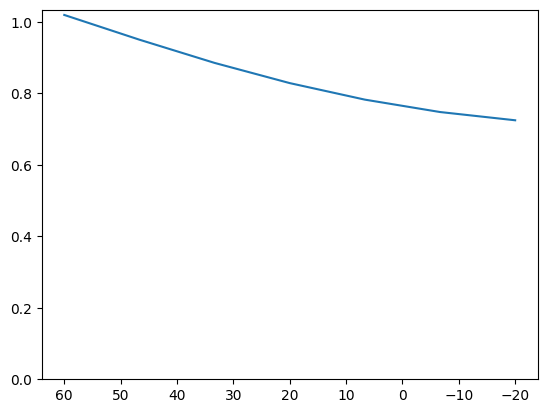

In [10]:
ita = np.linspace(60, -20, 7)

for a in np.linspace(0, 0.1, 11)[7:8]:
    thbs = np.array([thb(i, a) for i in ita])
    # plt.plot(WAVELENGTHS, thbs.T)
    plt.plot(ita, thbs)
plt.ylim([0, None])
plt.gca().invert_xaxis()

In [11]:
np.logspace(-2.3, -1.5, 11)[7]

0.018197008586099843

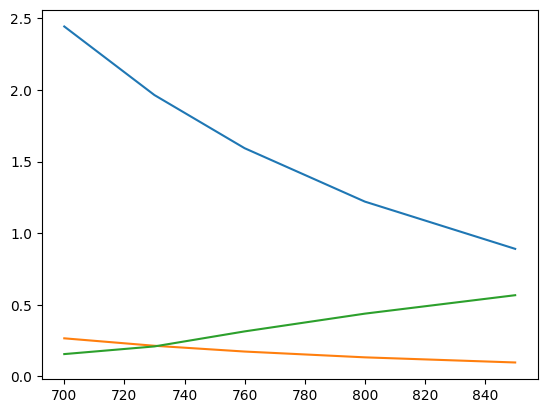

In [12]:
plt.plot(WAVELENGTHS, mua_melanin(WAVELENGTHS, ita_to_mvf(-20)))
plt.plot(WAVELENGTHS, mua_melanin(WAVELENGTHS, ita_to_mvf(60)))
plt.plot(WAVELENGTHS, mua_oxy_blood(WAVELENGTHS))